# Лабораторная работа 10

## Практика TensorFlow 2.x

Выполнил: 6231-010402D, Баканов Д.С.

### Задание

В данной лабораторной работе будет практиковаться материал из лекций по TensorFlow на примере решения задачи классификации изображений из датасета Fashion MNIST. Fashion MNIST - набор черно-белых изображений размера 28х28, что поделены на 10 классов. Будет построена с нуля и обучена модель логистической регрессии используя как низкоуровневый API. Опционально решение той же задачи нейронной сетью, построенной и обученной с использованием Keras.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tqdm import tqdm

warnings.filterwarnings("ignore")
np.random.seed(42)
print(tf.__version__)
print(tf.config.list_physical_devices())

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


0 Базовые операции. 
   - 0.1 Сгенерируйте три непересекающихся гауссовых облака, используя `tf.random`. Визуализируйте их разными цветами, используя matplotlib. 
   - 0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

(1947, 2)


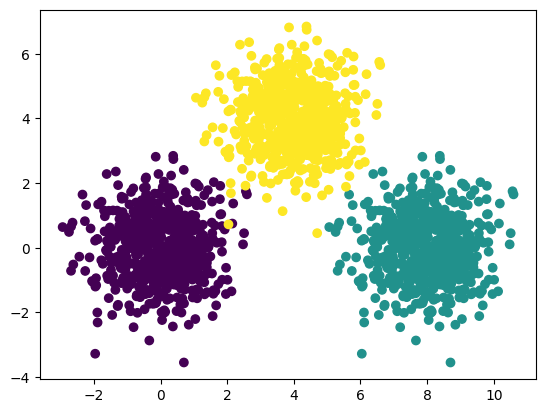

In [2]:
# 0.1
number_features = 2
number_samples = 649

mu = 0.0
sigma_square = 1.0
noise = mu + np.sqrt(sigma_square) * \
             tf.random.normal(shape=(number_samples, number_features))

a = 4
k = 2

clouds = [
    noise + np.array([0, 0]),
    noise + np.array([0 + k * a, 0]),
    noise + np.array([0 + k * a / 2, 0 + k * a / 2]),
]

X = np.vstack(clouds)
annotations = []
for i, cloud in enumerate(clouds):
    annotations += ([i] * cloud.shape[0])

print(X.shape)
plt.scatter(X[:,0], X[:,1], c=annotations)

(1947, 2, 2, 2)


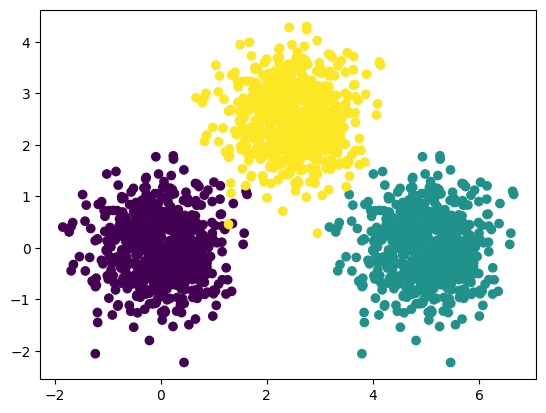

In [3]:
# 0.2

random_matrix = tf.random.normal(shape=(2, 2))
new_X = np.zeros(shape=(1947, 2, 2, 2))

num_rows, num_cols = X.shape
for i in range(num_rows):
    for j in range(num_cols):
        new_X[i, j] = X[i, j] * random_matrix


print(new_X.shape)
plt.scatter(new_X[:,0, 0, 0], new_X[:,1, 0, 0], c=annotations)

1 Загрузите датасет Fashion MNIST, используя метод из [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). Визуализируйте несколько изображений, используя библиотеку matplotlib.

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist

NUM_TRAIN = 10000
NUM_TEST = 1000

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
X_train = X_train[:NUM_TRAIN]
y_train = y_train[:NUM_TRAIN]

X_test = X_test[:NUM_TEST]
y_test = y_test[:NUM_TEST]

print(f"Тренировочный набор: X={X_train.shape}, y={y_train.shape}")
print(f"Тестовый набор данных: X={X_test.shape}, y={y_test.shape}")

Тренировочный набор: X=(10000, 28, 28), y=(10000,)
Тестовый набор данных: X=(1000, 28, 28), y=(1000,)


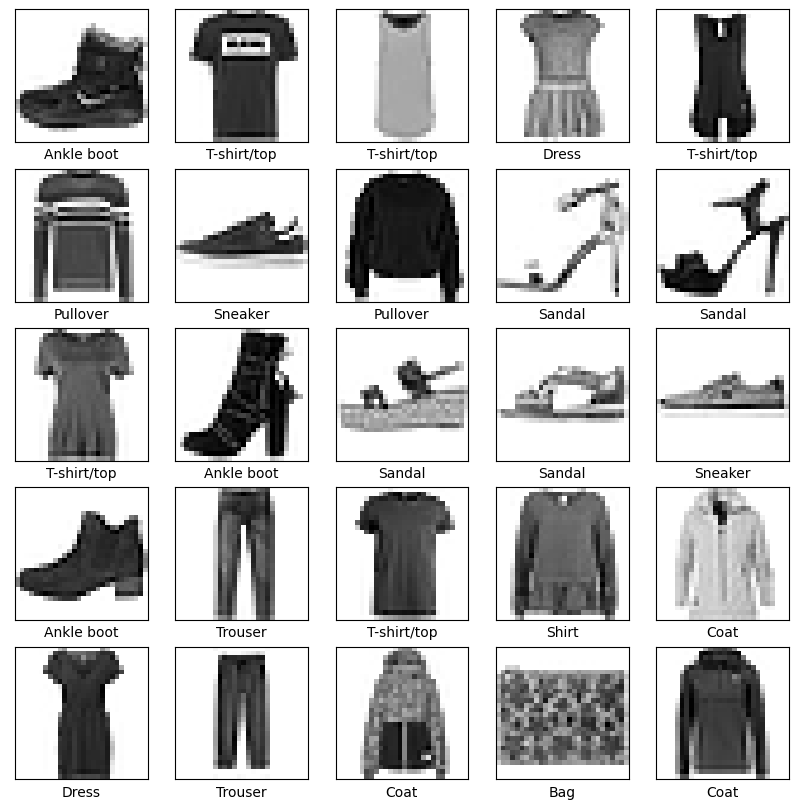

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

2 Нормализуйте данные либо средним и СКО, либо приведя значения пикселей в интервал [-1, 1].

In [6]:
mean, std = np.mean(X_train), np.std(X_train)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

3 Создайте обучающий и тестовый TensorFlow Dataset из нормализованного набора данных. К обучающему датасету добавьте перемешивание (`.shuffle`). К обоим датасетам добавьте генерацию батчей размера 128 (`.batch(128)`).

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=len(X_train), reshuffle_each_iteration=True)
test_dataset = test_dataset.shuffle(buffer_size=len(X_test), reshuffle_each_iteration=True)

train_dataset = train_dataset.batch(128, drop_remainder=True)
test_dataset = test_dataset.batch(128, drop_remainder=True)

In [8]:
next(iter(train_dataset))[0].shape

TensorShape([128, 28, 28])

4 Напишите класс слоя `Flatten`, что трансформирует изображения из матричного в векторный вид: [28, 28] -> [28 * 28]. Класс слоя должен наследоваться от `tf.Module`. Для трансформации тензоров изображений использовать `tf.reshape`.

In [9]:
class Flatten(tf.Module):

    def __init__(self, name=None):
        super().__init__(name=name)

    def __call__(self, data):
        if len(data.shape) == 1:
            new_shape = data.shape
        elif len(data.shape) == 2:
            new_shape = (1, np.prod(data.shape))
        else:
            new_shape = (data.shape[0], np.prod(data.shape[1:]))
        return tf.reshape(data, shape=new_shape)

5 Напишите класс линейного слоя `Linear`, что умножает входной вектор на матрицу весов. Класс слоя должен наследоваться от `tf.Module`. Матрицу весов хранить в `tf.Variable`. Параметры конструктора: `in_d` - размерность входного вектора, `out_d` - размерность выходного вектора. В качестве начальной инициализации весов использовать гауссово распределение с СКО=0.01.

In [10]:
class Linear(tf.Module):

    def __init__(self, in_d, out_d, name=None):
        super().__init__(name=name)
        w_ = tf.random.normal(shape=(in_d, out_d), stddev=0.01)
        self.W = tf.Variable(w_, name="weights" if name is None else f"{name}_weights")

    def __call__(self, X):
        return tf.matmul(np.array(X), np.array(self.W)).numpy()

6 Напишите класс модели логистической регрессии `LogisticRegression`, что компонует в себе слои `Linear` и `Flatten`. Класс модели должен наследоваться от `tf.Module`. В качестве функции активации используйте `tf.nn.softmax`.
Создайте объект модели и попробуйте с помощью неё классифицировать одно изображение (не забудьте о размерности батча! Она будет равна 1).

In [11]:
class LogisticRegression(tf.Module):

    def __init__(self, name="logistic_regression"):
        super().__init__(name=name)
        self.flatten = Flatten(name=f"{name}_flatten")

    def __call__(self, sample):
        flatten_sample = self.flatten(sample)
        linear = Linear(in_d=flatten_sample.shape[1], out_d=flatten_sample.shape[0])
        return tf.nn.softmax(linear(flatten_sample)).numpy()

(28, 28)


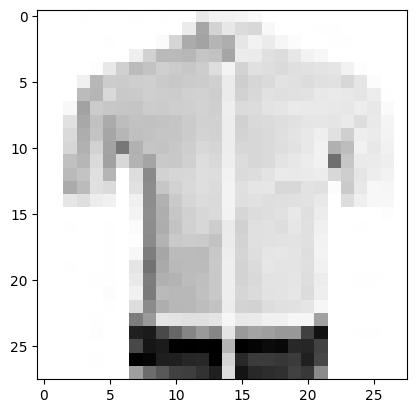

In [12]:
sample = next(iter(train_dataset))[0][0]
plt.imshow(sample, cmap=plt.cm.binary)
print(sample.shape)

In [13]:
logistic_regression = LogisticRegression()
logistic_regression(sample)

array([[1.]])

7 Напишите функцию оценки точности модели `evaluate`. Список её аргументов: тестовый tf.Dataset, модель. Данная функция будет отличаться оной из лекций тем, что внутри неё не будет ручной выборки батчей из датасета, поскольку tf.Dataset уже делает это за нас.

In [14]:
def accuracy(y_true, y_pred):
    eq = tf.cast(y_true == y_pred, 'float32')
    return tf.reduce_mean(eq)


def evaluate(model, data: tf.data.Dataset) -> np.ndarray:
    y_preds = []
    y_true = []

    for x_batch, y_batch in data:
        preds = model(x_batch)
        preds = tf.argmax(preds, axis=-1)
        y_preds.append(preds)
        y_true.extend(y_batch)

    y_preds = tf.concat(y_preds, axis=0)
    return accuracy(y_true, y_preds).numpy()

8 Напишите функцию обучающего шага `train_step`. Данная функция будет немного отличаться от показанной в лекции тем, что ей на вход также дается функция ошибки. Полный список аргументов: модель, тупл данных (батч картинок, батч меток), оптимизатор, функция ошибки. Функция `train_step` должна возвращать вычисленное значение функции ошибки.

В данной лабораторной функция ошибки не будет писаться заново, будет использоваться готовая кросс-энтропия из Keras.

In [15]:
def train_step(model, data, optimizer, func_loss) -> np.ndarray:
    with tf.GradientTape() as tape:
        x, y = data
        x = x.numpy()
        y = y.numpy()
        predictions = model(x)
        loss = func_loss(y, predictions)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss.numpy()

9 Оцените точность модели.

In [16]:
evaluate(logistic_regression, train_dataset)

0.0060096155

10 Подготовьте гиперпараметры обучения: оптимизатор, функция ошибки ([tf.keras.losses.SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)), количество эпох.

In [17]:
OPTIMIZER = tf.optimizers.Adam(learning_rate=0.01)
LOSS_FUNCTION = tf.losses.SparseCategoricalCrossentropy()
EPOCHS = 10

11 Напишите обучающий цикл. Цикл состоит из внешнего цикла, что отсчитывает эпохи, и вложенного, что итерируется по обучающему датасету.
Во вложенном цикле должна вызываться функция `train_step`. Каждую эпоху модель должна тестироваться функцией `evaluate`. Должны выводиться номер эпохи, значение ошибки и точности. Сохраняйте значения ошибки и точности в списки. Обучите модель. По ходу обучения подбирайте более оптимальные гиперпараметры обучения (learning_rate, другой оптимизатор).

In [19]:
history = {
    "accuracy": [],
    "loss": [],
}

for epoch in range(EPOCHS):
    print(f"Epochs: {epoch} / {EPOCHS} {'=' * 40}")
    loss_list = []
    accuracy_list = []
    for i, batch in enumerate(tqdm(train_dataset)):
        loss = train_step(logistic_regression, data=batch, optimizer=OPTIMIZER, func_loss=LOSS_FUNCTION)
        accuracy_value = evaluate(logistic_regression, test_dataset)
        loss_list.append(loss)
        accuracy_list.append(accuracy_value)

    mean_loss = np.mean(loss_list)
    mean_accuracy = np.mean(accuracy_list)

    history["accuracy"].append(mean_accuracy)
    history["loss"].append(mean_loss)

    print(f"Loss: {mean_loss}, Accuracy: {mean_accuracy}")

    print("=" * 55)

Epochs: 0 / 10 ========================================


100%|██████████| 78/78 [00:17<00:00,  4.57it/s]


Loss: 4.88391152247035, Accuracy: 0.007440476678311825
Epochs: 1 / 10 ========================================


100%|██████████| 78/78 [00:17<00:00,  4.54it/s]


Loss: 4.879450069802688, Accuracy: 0.00849931314587593
Epochs: 2 / 10 ========================================


100%|██████████| 78/78 [00:17<00:00,  4.56it/s]


Loss: 4.877141038568266, Accuracy: 0.007869735360145569
Epochs: 3 / 10 ========================================


100%|██████████| 78/78 [00:17<00:00,  4.47it/s]


Loss: 4.878493271199057, Accuracy: 0.00849931314587593
Epochs: 4 / 10 ========================================


100%|██████████| 78/78 [00:17<00:00,  4.56it/s]


Loss: 4.892351164621898, Accuracy: 0.007311698514968157
Epochs: 5 / 10 ========================================


100%|██████████| 78/78 [00:17<00:00,  4.57it/s]


Loss: 4.892540664857366, Accuracy: 0.007984203286468983
Epochs: 6 / 10 ========================================


100%|██████████| 78/78 [00:16<00:00,  4.59it/s]


Loss: 4.8913311053836095, Accuracy: 0.007311698514968157
Epochs: 7 / 10 ========================================


100%|██████████| 78/78 [00:17<00:00,  4.55it/s]


Loss: 4.893511079540808, Accuracy: 0.007898352108895779
Epochs: 8 / 10 ========================================


100%|██████████| 78/78 [00:17<00:00,  4.59it/s]


Loss: 4.902099505883041, Accuracy: 0.007512019947171211
Epochs: 9 / 10 ========================================


100%|██████████| 78/78 [00:16<00:00,  4.59it/s]

Loss: 4.893012134400113, Accuracy: 0.008170215412974358


12 Выведите графики точности и ошибки, используя matplotlib.

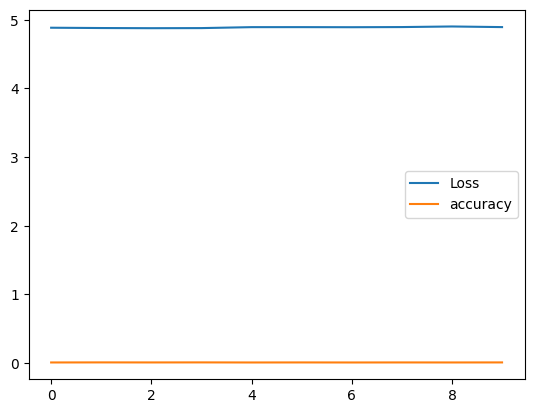

In [20]:
plt.plot(history["loss"], label="Loss")
plt.plot(history["accuracy"], label="accuracy")
plt.legend()

13 (Опционально) Постройте и обучите произвольную нейронную сеть с использованием Keras для решения той же задачи. 

In [21]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.optimizers import Adam

In [23]:
cnn_model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(32,activation='relu'),
    Dense(10,activation = 'softmax')
])

In [24]:
cnn_model.compile(loss ='sparse_categorical_crossentropy', optimizer=Adam(lr=0.01),metrics =['accuracy'])

In [25]:
history = cnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    verbose=1
)

Epoch 1/10
313/313 [==============================] - 3s 7ms/step - loss: 0.6625 - accuracy: 0.7731
Epoch 2/10
313/313 [==============================] - 2s 7ms/step - loss: 0.4103 - accuracy: 0.8549
Epoch 3/10
313/313 [==============================] - 2s 7ms/step - loss: 0.3674 - accuracy: 0.8696
Epoch 4/10
313/313 [==============================] - 2s 7ms/step - loss: 0.3384 - accuracy: 0.8815
Epoch 5/10
313/313 [==============================] - 2s 7ms/step - loss: 0.3134 - accuracy: 0.8886
Epoch 6/10
313/313 [==============================] - 2s 7ms/step - loss: 0.2945 - accuracy: 0.8948
Epoch 7/10
313/313 [==============================] - 2s 7ms/step - loss: 0.2849 - accuracy: 0.8995
Epoch 8/10
313/313 [==============================] - 2s 7ms/step - loss: 0.2661 - accuracy: 0.9023
Epoch 9/10
313/313 [==============================] - 2s 7ms/step - loss: 0.2584 - accuracy: 0.9036
Epoch 10/10
313/313 [==============================] - 2s 7ms/step - loss: 0.2711 - accuracy: 0.9032

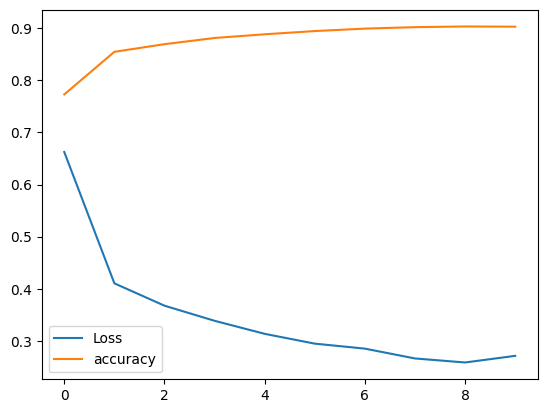

In [28]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["accuracy"], label="accuracy")
plt.legend()